In [1]:
#import seaborn as sns
from sklearn.metrics import mean_squared_error
#from datetime import date
import numpy as np 
import pandas as pd 
#import gc
import datetime
#import time
import csv
from sklearn.preprocessing import MinMaxScaler
#import os
import matplotlib.pyplot as plt
import random
import mylibs as l
from sklearn.linear_model import LinearRegression


from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation


#sns.set_palette('Set2')
%matplotlib inline

Using TensorFlow backend.


In [2]:
btc_data = pd.read_csv('BTC_DATA_fin.csv', index_col=0)
btc_data.index = pd.to_datetime(btc_data.index)

In [3]:
from keras.callbacks import TensorBoard

In [4]:
btc_data=btc_data[['BTC_Open', 'BTC_High', 'BTC_Low', 'BTC_Close', 'BTC_Volume',
       'BTC_Market_Cap','Holiday', 'MA7', 'SO',
       'Momentum_14', 'Momentum_7', 'Momentum_2']]
#shift data
features = btc_data.shift(1).dropna() #.drop('BTC_Close', 1)
target = btc_data['BTC_Close'][1:]
prediction_days = 90

In [5]:
features_train = features[:len(features)-prediction_days]
features_test = features[len(features)-prediction_days:]

target_train = target[:len(features)-prediction_days]
target_test = target[len(features)-prediction_days:]

In [6]:
X_min_max_scaler = MinMaxScaler()
y_min_max_scaler = MinMaxScaler()
features_train_scaled = pd.DataFrame(X_min_max_scaler.fit_transform(features_train), 
                                     columns=features_train.columns, index=features_train.index)
features_test_scaled = pd.DataFrame(X_min_max_scaler.transform(features_test),
                                    columns=features_test.columns,index=features_test.index)
target_train_scaled = y_min_max_scaler.fit_transform(target_train.values.reshape(-1, 1))
target_test_scaled = y_min_max_scaler.transform(target_test.values.reshape(-1, 1))

In [7]:
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                      write_graph=True, write_images=True) #write_images=False

In [8]:
def window_data(df, window_len):
    window_data = []
    for i in range(len(df) - window_len):
        tmp = df[i: (i + window_len)].copy()
        window_data.append(tmp.values)
    return np.array(window_data)

In [9]:
window_len=1
X_train = window_data(features_train_scaled, window_len=window_len)
X_test = window_data(features_test_scaled, window_len=window_len)
    
y_train = target_train_scaled[window_len:]
y_test = target_test_scaled[window_len:]

In [15]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
model.add(Dropout(0.5))
model.add(LSTM(56, return_sequences=True, activation='tanh'))
model.add(Dropout(0.3))
model.add(LSTM(30, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer='adam')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 1, 256)            275456    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 1, 56)             70112     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 56)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 30)                10440     
_________________________________________________________________
dropout_9 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
__________

In [16]:
epochs = 50 #100
batch_size=10
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[tensorboard]) #valid=0.2#,shuffle=True

Train on 1750 samples, validate on 195 samples
Epoch 1/50
1750/1750 [==============================] - 2s 1ms/step - loss: 0.0071 - val_loss: 0.0023
Epoch 2/50
1750/1750 [==============================] - 2s 1ms/step - loss: 0.0016 - val_loss: 7.0510e-04
Epoch 3/50
1750/1750 [==============================] - 2s 1ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 4/50
1750/1750 [==============================] - 2s 973us/step - loss: 0.0012 - val_loss: 4.9756e-04
Epoch 5/50
1750/1750 [==============================] - 2s 979us/step - loss: 0.0010 - val_loss: 0.0034
Epoch 6/50
1750/1750 [==============================] - 2s 992us/step - loss: 9.2106e-04 - val_loss: 4.0837e-04
Epoch 7/50
1750/1750 [==============================] - 2s 1000us/step - loss: 9.4835e-04 - val_loss: 2.8210e-04
Epoch 8/50
1750/1750 [==============================] - 2s 997us/step - loss: 9.3442e-04 - val_loss: 2.0128e-04
Epoch 9/50
1750/1750 [==============================] - 2s 1ms/step - loss: 0.0010 - val_loss:

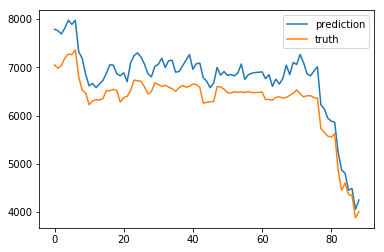

In [17]:
preds = model.predict(X_test)
preds= y_min_max_scaler.inverse_transform(preds)
y_test=y_min_max_scaler.inverse_transform(y_test)
plt.plot(preds, label='prediction')
plt.plot(y_test, label='truth')
plt.legend()
plt.show()

In [18]:
np.sqrt(mean_squared_error(y_test,preds))

467.31290059898504